# Analysing the NYC Subway Dataset
## Data Analyst Nanodegree Program - Udacity
*Surya Kallakuri*

In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
import statsmodels.api as sm
import random
from ggplot import *

# Set global seeds for reproducibility
np.random.seed(1072015)
random.seed(1072015) 

twdf = pd.read_csv('data/turnstile_weather_v2.csv') # Load the improved dataset
eh_rain = twdf[twdf.rain == 1].ENTRIESn_hourly # Get entries by hour with rain
eh_norain = twdf[twdf.rain == 0].ENTRIESn_hourly # Get entries by hour witouth rain

### Section 0. References

1. [Easily create train and test samples](http://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas)

2. [Remove constant columns](http://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column)

3. [Residuals analysis](http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm)

4. [R<sup>2</sup> interpretation](https://en.wikipedia.org/wiki/Coefficient_of_determination#Interpretation)

5. [Custom axis tick label names in ggplot](http://stackoverflow.com/questions/23564607/how-to-change-x-axis-tick-label-names-order-and-boxplot-colour-using-r-ggplot)

6. [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)

7. [Machine Learning Course](https://www.coursera.org/learn/machine-learning/)

8. [Scipy documentation for Mann–Whitney U test](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu)

9. [Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)



### Section 1. Statistical Test

#### 1.1 Which statistical test did you use to analyse the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

We used the Mann-Whitney U test. We wanted to analyse if the distribution of ridership in rainy days provides statistically significant larger/smaller values than the distribution in days without rain. Since it is hard to determine a priori the directionality of a possible difference, we used a two-tail p-value. Our null hypothesis was that the distributions of both groups were the same, so there was a 50% probability that an observation from a value randomly selected from one population exceeds an observation randomly selected from the other population. Our p-critical value was 0.05.

#### 1.2 Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

One of the assumptions to perform a t-test is that we are working with a normal distribution. After analysing a histogram of ridership for rainy and non-rainy days we can see that they have non-normal distributions: 

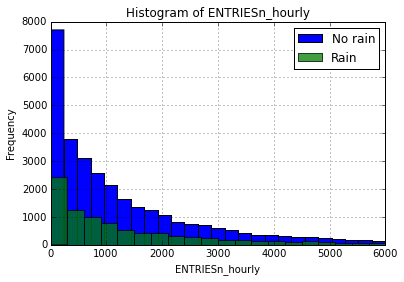

In [5]:
plt.figure()
twdf[(twdf.rain == 0) & (twdf.ENTRIESn_hourly <= 6000)]['ENTRIESn_hourly'].hist(bins = 25, label = 'No rain') 
twdf[(twdf.rain == 1) & (twdf.ENTRIESn_hourly <= 6000)]['ENTRIESn_hourly'].hist(bins = 20, alpha = 0.75, label = 'Rain') 
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Frequency')
plt.title('Histogram of ENTRIESn_hourly')
plt.legend()
plt.show()

This is corroborated by the Shapiro-Wilk test, which returns a p-value that is close to 0 for both distributions when checking for normality. So in this case we reject the null hypothesis (normality):

In [6]:
(W, p) = ss.shapiro(random.sample(eh_rain, 1000)) # We need only a random sample to check normality
print 'The shapiro test for the rain distribution is {:.3}, with a p-value of {}'.format(W, p)
(W, p) = ss.shapiro(random.sample(eh_norain, 1000)) # We need only a random sample to check normality
print 'The shapiro test for the non-rain distribution is {:.3}, with a p-value of {}'.format(W, p)

The shapiro test for the rain distribution is 0.574, with a p-value of 6.30584308946e-44
The shapiro test for the non-rain distribution is 0.618, with a p-value of 2.49150866957e-42


An alternative to the t-test is to use a non-parametric test, like Mann-Whitney U test, which does not make any assumptions about the distribution. Furthermore, its efficiency is similar to that from t-test when we have large samples, like in this case:

In [7]:
print '- number of records for rainy days: {:,}'.format(len(eh_rain))
print '- number of records for non-rainy days: {:,}'.format(len(eh_norain))

- number of records for rainy days: 9,585
- number of records for non-rainy days: 33,064


#### 1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

In [8]:
with_rain_mean = np.mean(eh_rain)
without_rain_mean = np.mean(eh_norain)
(U, p) = ss.mannwhitneyu(eh_rain, eh_norain)
print '- Mann-Whitney U value: {:,.12}'.format(U)
print '- p-value: {:.6} (one-tail p-value, the default in scipy.stats.mannwhitneyu)'.format(p)
print '- Mean entries for rainy days: {:,.6}'.format(with_rain_mean)
print '- Mean entries for non-rainy days: {:,.6}'.format(without_rain_mean)

- Mann-Whitney U value: 153,635,120.5
- p-value: nan (one-tail p-value, the default in scipy.stats.mannwhitneyu)
- Mean entries for rainy days: 2,028.2
- Mean entries for non-rainy days: 1,845.54


#### 1.4 What is the significance and interpretation of these results?

The two-tail p-value would be the double, because we have to multiply by 2 the one-tail p-value obtained from scipy.stats.mannwhitneyu test. Our p-critical value is 0.05. This means that we would reject the null hypothesis for p-values lower or equal of 0.05. Since it is our case, we reject the null hypothesis. After analysing the means, we could have the idea that maybe the directionality is toward rainy days (they have more ridership entries), but it will require further analysis.

### Section 2. Linear Regression

*Some useful functions to answer the questions:*

In [9]:
def plot_residuals(values, predictions):
    """
    Plot the error distribution (residuals): difference between the real value and the predicted value.
    """
    plt.figure()
    pd.DataFrame((values - predictions)).hist(bins = 50)
    plt.xlabel('Residuals')
    plt.ylabel('Relative frequency')
    plt.title('Residuals Distribution')
    return plt
    
    
def compute_r_squared(data, predictions):
    """
    Computes the R squared using the real data and the predicted data.
    """
    r_squared = 1 - (np.sum((data - predictions) ** 2) / np.sum((data - np.mean(data)) ** 2))
    return r_squared


def createSubsets(features, values):
    """
    Divides a dataset (features + values) into 3 random subsets. The distribution is approximately:
    - 60% for training set
    - 20% for validation set
    - 20% for test set
    """
    msk = np.random.rand(len(values)) <= 0.6 # 60 % for training
    trainF = features[msk]  
    trainV = values[msk]
    remainingF = features[~msk]
    remainingV = values[~msk]
    msk = np.random.rand(len(remainingV)) <= 0.5 # the remaining (40%) is 50% for test and 50% for validation
    testF = remainingF[msk]
    testV = remainingV[msk]
    validationF = remainingF[~msk]
    validationV = remainingV[~msk]
    
    # Remove constant features (training set) in all the sets
    msk = (trainF != trainF.ix[min(trainF.index)]).any()
    for i in range(0, len(msk)):
        if (msk[i] == False):
            print 'Warning constant feature removed: {}'.format(trainF.columns.values[i])
    
    return trainF.loc[:, msk], trainV, testF.loc[:, msk], testV, validationF.loc[:, msk], validationV


def getPredictions(features, intercept, params):
    """
    Calculate the predictions using the feature values and the model parameters (including intercept).
    """
    predictions = intercept + np.dot(features.values, params)
    return predictions


def normalize_features(features):
    """
    Normalize features (substract mean and divide by starndar deviation).
    """
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means) / std_devs
    return means, std_devs, normalized_features


def recover_params(means, std_devs, norm_intercept, norm_params):
    """
    Recover original values of normalized features. Also recover the intercept withouth the 'spare capacity' that
    includes in the model with normalized features.
    """
    intercept = norm_intercept - np.sum(means * norm_params / std_devs)
    params = norm_params / std_devs
    return intercept, params

#### 2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model?

Ordinary Least Squares (OLS) using Statsmodels package.

#### 2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

From the improved dataset, we have used 6 features: "tempi", "precipi", "pressurei", "UNIT", "hour" and "day_week". The last three are dummy variables.

In [10]:
# First, take numerical features and normalize them
features = twdf[['tempi', 'precipi', 'pressurei']]
mean, std_devs, features = normalize_features(features)
numNumericalFeatures = len(features.columns) # To know the number of features for recovering of normalization

# Add dummy variables (dropping 1 column to avoid multicollinearity, because we will include a constant term)
features = features.join((pd.get_dummies(twdf['UNIT'], prefix='unit').ix[:,1:]))
features = features.join((pd.get_dummies(twdf['hour'], prefix='hour').ix[:,1:]))
features = features.join((pd.get_dummies(twdf['day_week'], prefix='dayname').ix[:,1:]))

# Set the dependent variable
values = twdf['ENTRIESn_hourly']

#### 2.3 Why did you select these features in your model?

We thought that the most important predictors would the station, the day of the week and the hour of the day. After some tests, we saw that "UNIT" was a better predictor than the station name. It is logical because the dependent variable ("ENTRIESn_hourly") is related to a specific UNIT. We also thought that meteorological conditions could influence the behaviour of the users. We included "rain", "fog", "wsdpi", "tempi", "precipi", "pressurei". We used them instead mean, max or min values because we thought the "current" weather condition was that detected by the user, so this helps to decide if to take or not the subway. The results of the model summary told us that "rain", "fog" and "wsdpi" didn't have a good contribution to the model (they had high p-values and also their confidence interval included the 0 value).

#### 2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?

First, we divided the data into 3 subsets:

- train (~60%): for training the model
- validation (~20%): for evaluation different features and model configurations, and detecting overfitting
- test (~20%): to report the final R<sup>2</sup> with unseen data

In [11]:
trainF, trainV, testF, testV, validationF, validationV = createSubsets(features, values)
model = sm.OLS(trainV, sm.add_constant(trainF)).fit() # Fit the model, adding a constant value
intercept = model.params[0]
params = model.params[1:]

The params for the non-dummy features, before recovering them from normalization, are:

In [12]:
params[0:numNumericalFeatures]

tempi       -136.572086
precipi      -47.561119
pressurei    -58.431362
dtype: float64

And the recovered parameters are:

In [13]:
rec_intercept, rec_params = recover_params(mean, std_devs, intercept, params[0:numNumericalFeatures])
rec_params

tempi         -16.151868
precipi     -1841.227365
pressurei    -423.599974
dtype: float64

#### 2.5 What is your model’s R<sup>2</sup> (coefficients of determination) value?

After training the model, we obtain this R<sup>2</sup> value:

In [14]:
predictions = getPredictions(trainF, intercept, params)
r2 = compute_r_squared(trainV, predictions)
print 'Training R^2: {:.3}'.format(r2)

Training R^2: 0.547


According to the residuals analysis, the behaviour of our model looks normal. Error distribution is approximately normal, more or less independently distributed and with mean around 0:

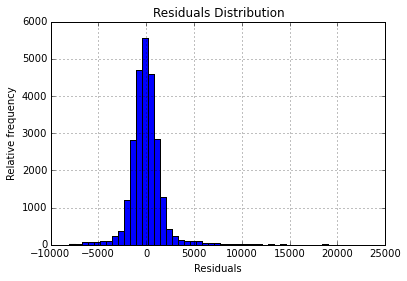

In [15]:
plot_residuals(trainV, predictions).show()

But there is a problem, which it is not easy to appreciate.  The histogram has a very large right tail. This indicates very large values for some residuals. We can use a Q-Q plot to check if the quantiles of our residuals distribution are similar to those from a standard normal distribution:

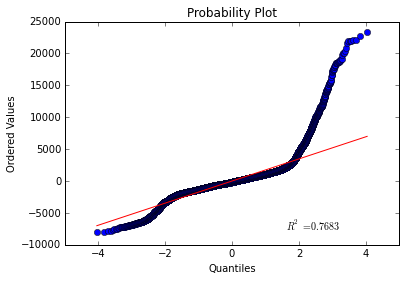

In [16]:
probplot = ss.probplot(trainV-predictions, plot=plt)

We can see that the adjustment is not perfect for bottom quantiles, but the big problem is in the upper quantiles. If we plot the values of the dependent variable (ENTRIESn_hourly) with their corresponding absolute residual, we can appreciate big deviations toward the larger values:

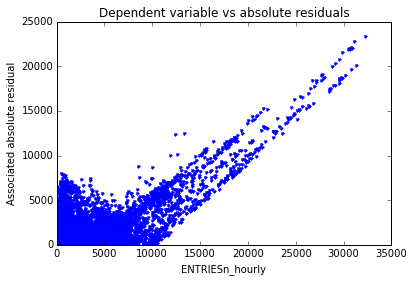

In [17]:
plt.plot(trainV, abs(trainV-predictions), '.')
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Associated absolute residual')
plt.title('Dependent variable vs absolute residuals')

It is clear that our model has an underlying problem. We will discuss further in the next point. By the moment, lets check if our model could have other problem: overfitting. The R<sup>2</sup> values for the validation and test sets are:

In [18]:
predictions = getPredictions(validationF, intercept, params)
r2 = compute_r_squared(validationV, predictions)
print 'Validation R^2: {:.3}'.format(r2)

predictions = getPredictions(testF, intercept, params)
r2 = compute_r_squared(testV, predictions)
print 'Test R^2: {:.3}'.format(r2)

Validation R^2: 0.533
Test R^2: 0.544


These values are very similar to that obtained from the training set, so we can say that our model does not have an overfitting problem.

#### 2.6 What does this R<sup>2</sup>  value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R<sup>2</sup>   value?

Our R<sup>2</sup> value indicates that our regression model can explain almost 55% of the variance in the response variable. This is a modest value, although could be acceptable depending on the circumstances. It would be preferable to get a model that explains at least 70-75% of the variance. In any case, the analysis of residuals told us that there is an underlying problem. Large values have very large residuals. The problem also happens with small values, but the impact is much lower. If we plot the dependent variable of the train set (with its original order: UNIT-date-time) versus their residuals (according to our predictive model), we can appreciate a pattern:

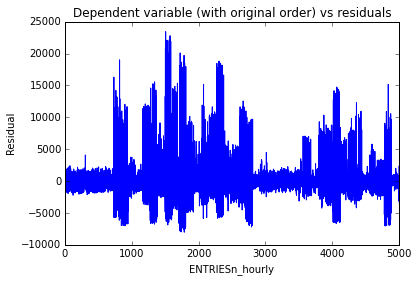

In [19]:
predictions = getPredictions(trainF, intercept, params)
plt.plot((trainV-predictions)[0:5000])
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Residual')
plt.title('Dependent variable (with original order) vs residuals')

We have plotted only the first 5.000 rows in order to see better the pattern. That means that there is something that our linear model is not able to capture. So a good idea for future work is to investigate non-linear models.

### Section 3. Visualization

#### 3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.

See figure in section 1.2 above.

#### 3.2 One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. 

As expected, the number of users in weekends is much lower:

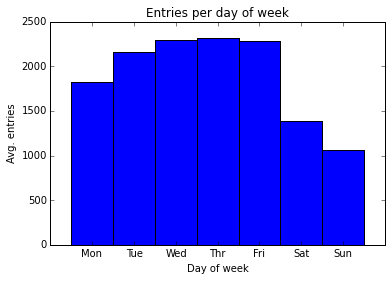

<ggplot: (32416302)>

In [20]:
entries_by_day_df = twdf[['day_week', 'ENTRIESn_hourly']].groupby('day_week').mean()
ggplot(aes(x=entries_by_day_df.index, y="ENTRIESn_hourly"), entries_by_day_df) + geom_bar(stat = 'bar', fill = 'blue') + \
    xlab('Day of week') + ylab('Avg. entries') + ggtitle('Entries per day of week') + theme_matplotlib() + \
    scale_x_discrete(labels=['', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun', ''] )

### Section 4. Conclusion

#### 4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?

More people ride the NYC subway when it is raining.

#### 4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.

As expected, the number of non-rainy days is much larger than the number of rainy days. Then we should focus on the average ridership of non-rainy days vs rainy days and their different distributions. We use a Mann-Whitney U test to determine if there is a significant difference in their means. This test does not make any assumption about the type of distribution; in contrast with the t-test, which requires a normal distribution (and this is not our case). Our null hypothesis is that the mean of both distributions is the same. The test gives us a two-tail p-value that is slightly lower than our p-critical value (0.05), so we reject the null hypothesis: the distributions have different means. Although we should perform deeper analysis, we think that the directionality is toward rainy days because the mean number of ridership is larger. 

The results of our linear regression analysis could make us to think in a different way. We have seen that the feature that indicates rainy days ("rain") was not significant in the model (low p-value and includes 0 in the confidence interval). We include a related feature, "precipi". In the resulting model, its coefficient is negative, which suggest a negative impact in the number of ridership if we keep fixed the other features. But since we have many features (considering the dummy variables), it is difficult to measure the real impact of "precipi" feature. So we consider our model is only valid for predictions, not for inference. 

### Section 5. Reflection

#### 5.1 Please discuss potential shortcomings of the methods of your analysis.

Regarding the statistical test, it should be complemented with a test that could help us to determine the directionality of the difference between the distributions. Also we think that we should summarize the records by station, date and time. Currently they are summarised by UNIT. It could be a little confusing. A UNIT could be broken one day, and then the distribution of ridership between the UNITs of one station will change. And also sometimes the station could change the type of the UNIT: only in, only out or in/out. To summarise the data by station-date-day could provide a more robust dataset. 

In the case of the predictive model, maybe the next steps could be to analyse possible interactions between the features. Currently we are not taking into account this possibility. And, as we have seen in our residual analysis, our linear model is not able to capture all the variability of our data. Large values of our dependent variable are associated with very large residuals. Furthermore, there is an underlying cyclic non-linear patter in our residuals, which suggest us to try to use a predictive non-linear model.

Another important thing, maybe for a future new analysis, is to take into account that maybe the non-rainy days are more probable in Summer, when there are more people in holydays (and then less people use subway).

#### 5.2 (Optional) Do you have any other insight about the dataset that you would like to share with us?

It would be a good idea to include a feature that indicates if it is a festive day in NYC. It could drastically change the results for these days. Also could be included some statistics about the usual periods of holydays. Finally, other types of problems that could push people (or not) to the subway: traffic accidents, train breakdowns, periods with more broken cars (i.e. by freezing in Winter),...

And finally, the dataset focuses on current weather condition or the max/min/average daily condition. Maybe people take the decision about their transport in the previous day, taking into account the weather forecast. So the predictions of the day before could be included as features.
